In [73]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [74]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [75]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc


In [76]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [77]:
# Declare a Base using `automap_base()`
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

In [78]:
# Print all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [79]:
# Assign the measurement class to a variable called `Measurement`
Measurement = Base.classes.measurement

# Assign the station class to a variable called `Station`
Station = Base.classes.station

In [80]:
# Create a session
session = Session(engine)

# Exploratory Precipitation Analysis

In [81]:
# Find the most recent date in the data set.
session.query(func.max(Measurement.date)).all()[0]

('2017-08-23',)

In [82]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.
most_recent_date = session.query(func.max(Measurement.date)).scalar()

In [83]:
# Calculate the date one year from the last date in data set.
one_year_ago = pd.to_datetime(most_recent_date) - pd.DateOffset(years=1)
one_year_ago = one_year_ago.strftime("%Y-%m-%d")

In [84]:
# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp)\
    .filter(Measurement.date >= one_year_ago)\
    .order_by(Measurement.date).all()

In [85]:
# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

In [86]:
# Sort the dataframe by date
df = df.sort_values('Date')

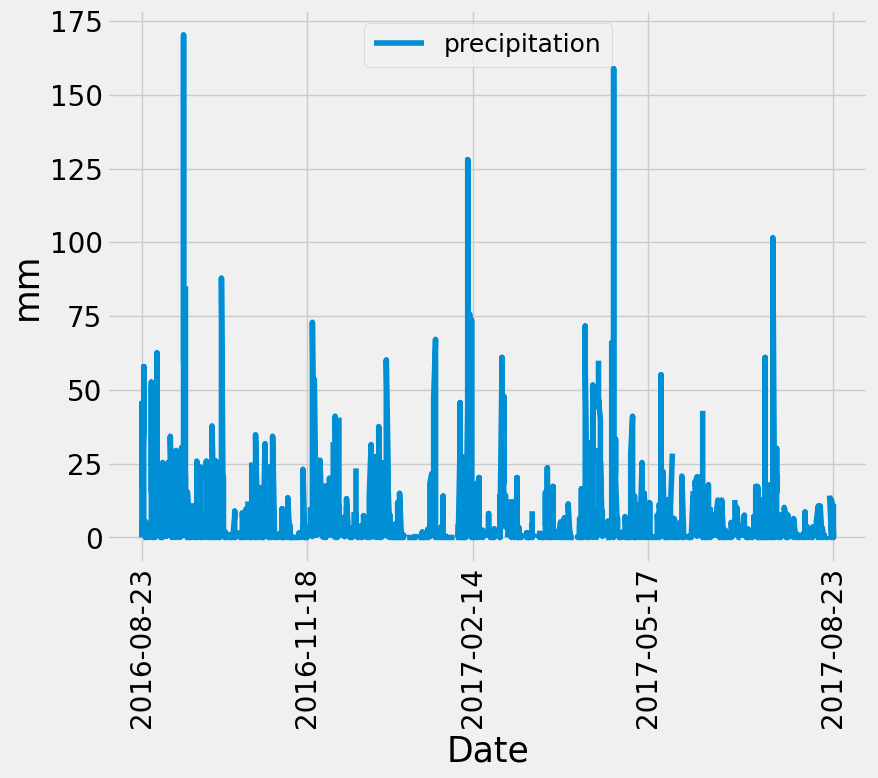

In [87]:
# Use Pandas Plotting with Matplotlib to plot the data:
plt.figure(figsize=(9, 8))
plt.plot(df['Date'], df['Precipitation'], label='precipitation')
plt.xlabel('Date', fontsize=25)
plt.ylabel('mm', fontsize=25)

# formatting to display only 5-dates.
num_dates = 5
step = len(df) // (num_dates - 1)
selected_dates = df['Date'][::step]

plt.xticks(selected_dates, rotation=90, fontsize=20)
plt.yticks(fontsize = 20)
plt.legend(loc='upper center', fontsize=18)
plt.tight_layout()
plt.show()

In [88]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = df['Precipitation'].describe()
summary_statistics = pd.DataFrame(summary_statistics)
summary_statistics

,Precipitation
count,2021.000000
mean,4.505888
std,11.713487
min,0.000000
25%,0.000000
50%,0.500000
75%,3.300000
max,170.200000


# Exploratory Station Analysis

In [89]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.id)).all()
print(total_stations)

[(9,)]


In [90]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.id))\
    .group_by(Measurement.station)\
    .order_by(desc(func.count(Measurement.id)))\
    .all()

most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [91]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = most_active_stations[0][0]

temperature_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs))\
    .filter(Measurement.station == most_active_station_id)\
    .all()

temperature_stats

[(12.2, 29.4, 22.03582251082252)]

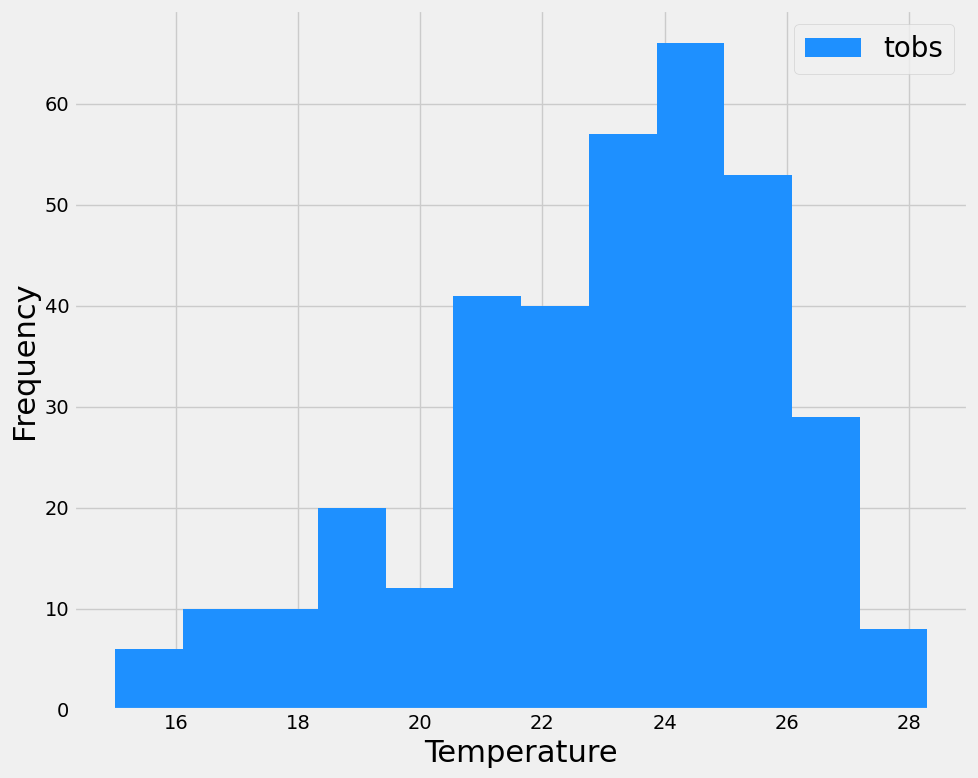

In [92]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data = session.query(Measurement.tobs)\
    .filter(Measurement.station == most_active_station_id)\
    .filter(Measurement.date >= one_year_ago)\
    .all()

# Extract temperature observations from the query results
temperatures = [temp[0] for temp in temperature_data]

# Create a histogram plot
plt.figure(figsize=(10, 8))
plt.hist(temperatures, bins=12, color='dodgerblue', label='tobs')
plt.xlabel('Temperature',fontsize = 22)
plt.ylabel('Frequency', fontsize=22)
plt.grid(True)
plt.legend(loc='upper right', fontsize=20)
plt.tight_layout()
plt.show()

# Close Session

In [93]:
# Close Session
session.close()